In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')

import read_data
from tools import smape

In [2]:
STD_FILLER = -1

data = read_data.data()
prot, pept = data.x_data_3d()
clinical = data.y_data_3d()



#Preprocessing

clinical_cols = list(set(list(zip(*clinical.columns))[0]))
prot_cols = list(set(list(zip(*prot.columns))[0]))
prot_means = {_: prot[_].mean().mean() for _ in prot_cols}
clinical_means = {_: clinical[_].mean().mean() for _ in clinical_cols}

def calc_lingress(row):
    if row.isnull().all():
        return pd.Series([np.nan, np.nan, np.nan])
    mask = ~np.isnan(row)
    if mask.sum()==1:
        return pd.Series([0, row[mask].iloc[0], STD_FILLER])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(row.index[mask], row[mask])
    return pd.Series([slope, intercept, std_err])

x = None
y = None

# letzten monate kommen haufiger vor...
for i in [5, 10, 15, 20]:
    #clinical
    col_titles = ['slope', 'intercept']#['slope', 'intercept', 'std_err']
    df = pd.DataFrame(columns=pd.MultiIndex.from_tuples([(_, __) for __ in col_titles for _ in clinical_cols], names=['Prot', 'feature']), index=clinical.index)
    for col in clinical_cols:
        vals = clinical[col].iloc[:, : i].apply(calc_lingress, axis=1)
        df[col, 'slope'] = vals[0].fillna(0)
        df[col, 'intercept'] = vals[1].fillna(clinical_means[col])
        #df[col, 'std_err'] = vals[2].fillna(STD_FILLER)
    clinical_df = np.array(df)

    #prot
    df = pd.DataFrame(columns=pd.MultiIndex.from_tuples([(_, __) for __ in ['slope', 'intercept', 'std_err'] for _ in prot_cols], names=['Prot', 'feature']), index=prot.index)
    for col in prot_cols:
        vals = prot[col].iloc[:, : i].apply(calc_lingress, axis=1)
        df[col, 'slope'] = vals[0].fillna(0)
        df[col, 'intercept'] = vals[1].fillna(prot_means[col])
        df[col, 'std_err'] = vals[2].fillna(STD_FILLER)
    prot_df = np.array(df)

    if x is None:
        x = prot_df
        y = clinical_df
    else:
        x = np.concatenate([x, prot_df])
        y = np.concatenate([y, clinical_df])

In [3]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(x)

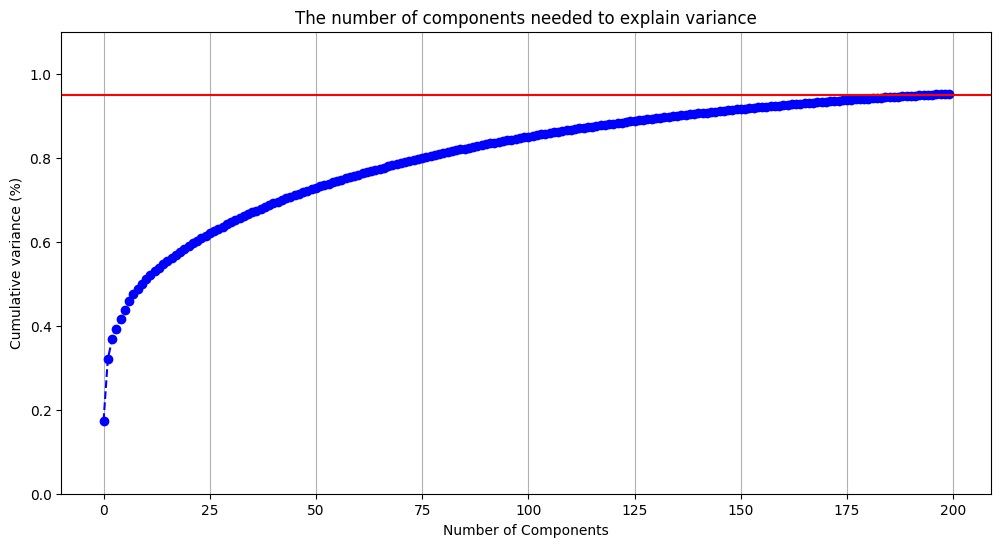

In [4]:
component_nr = 200

pca = PCA(component_nr).fit(data_rescaled)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(component_nr)
yi = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')

ax.grid(axis='x')
plt.show()

In [5]:
x.shape

(992, 681)

In [6]:
from sklearn.ensemble import RandomForestRegressor

In [7]:
regr = RandomForestRegressor(max_features="sqrt")
regr.fit(pca.transform(data_rescaled), y)

RandomForestRegressor(max_features='sqrt')

In [8]:
np.sqrt(np.mean((regr.predict(pca.transform(data_rescaled))-y)**2))

1.0668124165363124

In [11]:
smape_list = []
for item in range(-20, -1):
    res = regr.predict(pca.transform(data_rescaled)[item:])[0]
    pred_vals = []
    real_vals = []
    for i in range(4):
        for index in clinical[clinical_cols[i]].iloc[item].index:
            a, b = index*res[i]+res[4+i], clinical[clinical_cols[i]].iloc[item].loc[index]
            pred_vals.append(a)
            real_vals.append(b)
            #print(a, ' - ', b)
    real = np.array(real_vals)
    pred = np.array(pred_vals)
    pred = pred[~np.isnan(real)]
    real = real[~np.isnan(real)]
    print(smape(pred, real))
    smape_list.append(smape(pred, real))

63.79229226294723
27.538773422839142
52.34377657833906
51.450960459322715
130.09067785961358
115.85887962342083
105.67350589323902
48.53719228777453
36.065791946365714
131.78282290637517
82.02380410981111
29.91196354031737
34.248417465293514
39.919994176330434
70.34966834021115
107.4391237930302
44.38721002854435
57.56756829354398
26.92888659224304


In [13]:
sum(smape_list)/len(smape_list)

66.10059524102958

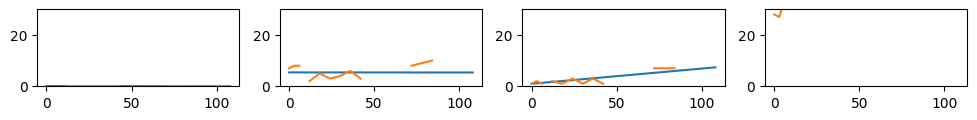

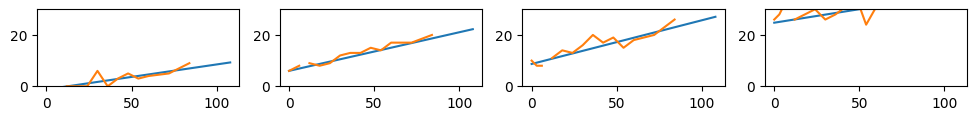

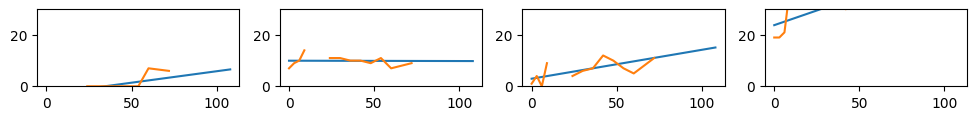

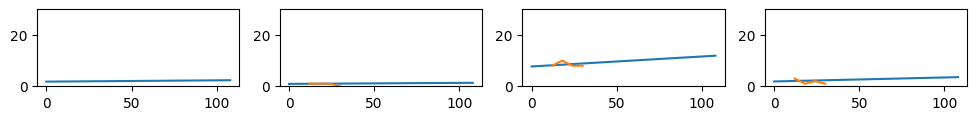

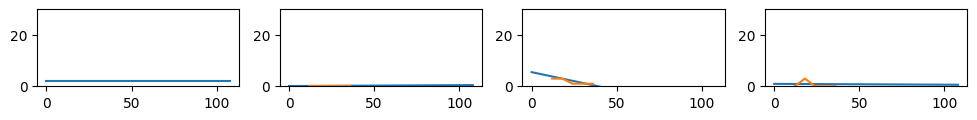

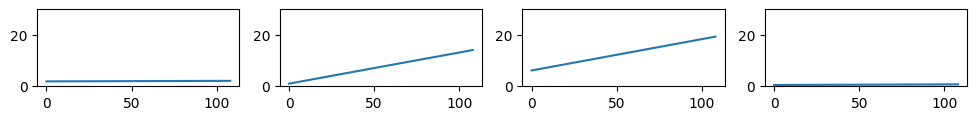

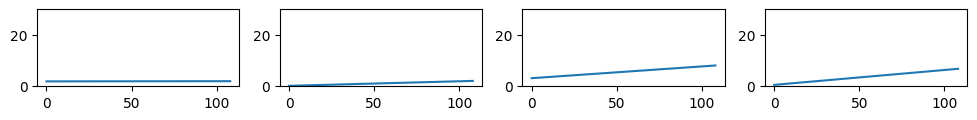

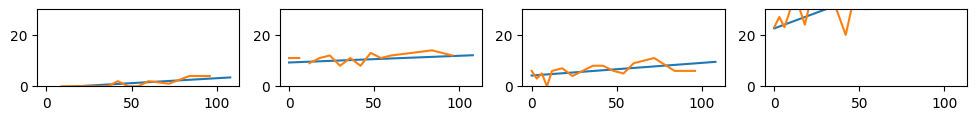

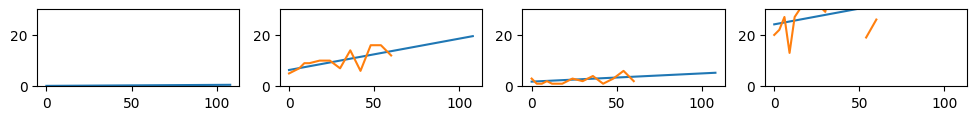

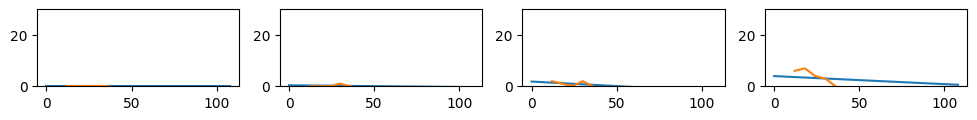

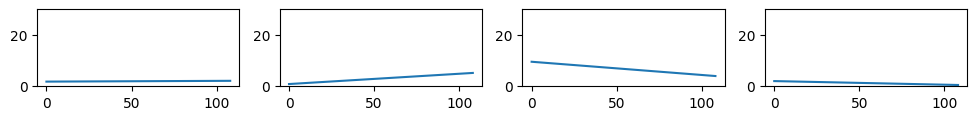

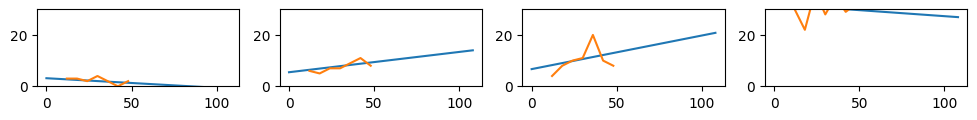

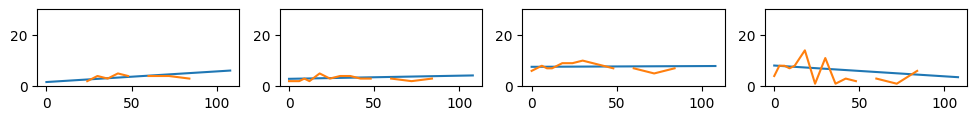

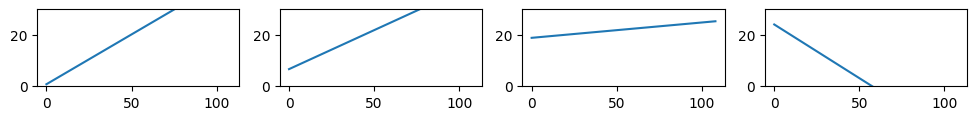

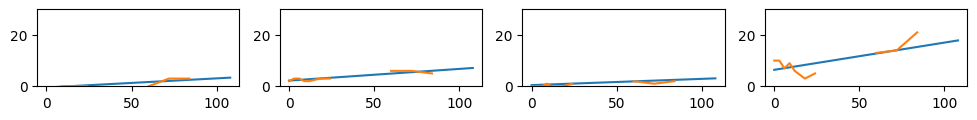

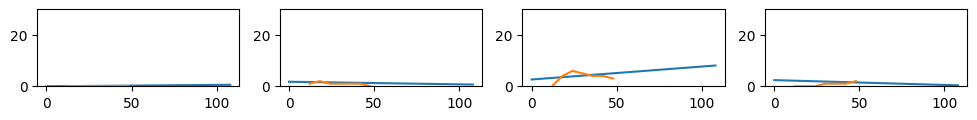

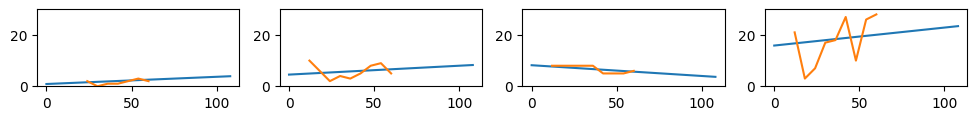

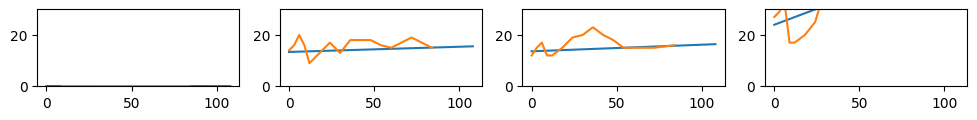

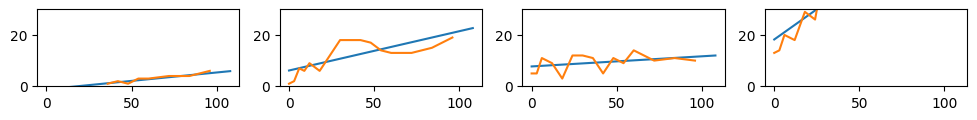

In [10]:
for item in range(-20, -1):
    res = regr.predict(pca.transform(data_rescaled)[item:])[0]
    plt.figure(figsize=(12,1))
    for i in range(4):
        pred_vals = []
        real_vals = []
        for index in clinical[clinical_cols[i]].iloc[item].index:
            a, b = index*res[i]+res[4+i], clinical[clinical_cols[i]].iloc[item].loc[index]
            pred_vals.append(a)
            real_vals.append(b)

        plt.subplot(1,4,1+i)
        plt.plot(clinical[clinical_cols[i]].iloc[item].index, pred_vals)
        plt.plot(clinical[clinical_cols[i]].iloc[item].index, real_vals)
        plt.ylim(0, 30)